# Dysfunctional seed dispersal in the endemic flora of Madagascar

* Language: R
* Methods: linear regression, multivariate imputation by chained equations (MICE), spatial analyses
* Associated publication: (in prep)

In [3]:
library(raster);
library(igraph);

<br>
<br>
## Data analyses

###### Average number of potential dispersers for each species s (over all datasets)

In [5]:
## Load data
load(file="distrAreaTot.rda")
load(file="distrCoLemurTot.rda")
load(file="distrDispCoLemurTot.rda")
load(file="distrDispLemurTot.rda")

traitveg<-read.csv("PT-data-miceP.csv")
species <- subset(traitveg, .imp=="0", select=.id, drop=TRUE)

## Prepare containers
DispLem <- data.frame(Species=species, Mean=rep(NA, length(species)), row.names=1)
CoLem <- data.frame(Species=species, Mean=rep(NA, length(species)), row.names=1)
DispCoLem <- data.frame(Species=species, Mean=rep(NA, length(species)), row.names=1)


## Loop through every plant species
for (s in species) {
	for (d in 1:20) {

	if (s %in% names(distrDispLemurTot[[d]])) {      # check whether the species is considered as endozoochorous in the dataset d

        if("no gbif data" %in% distrDispLemurTot[[d]][[s]]){ # if there is no gbif data (i.e. distribution data)
			DispLem[s, d+1] <- 1000                  # then, we give a dummy value (1000)
			CoLem[s, d+1] <- 1000
			DispCoLem[s, d+1] <- 1000
		} else {

			## Number of dispersers according to seed size only
			nbLemDisp <- length(distrDispLemurTot[[d]][[s]])
			DispLem[s, d+1] <- nbLemDisp

			## Number of dispersers according to distribution only (co-occurring lemurs)
			if (class(distrCoLemurTot[[d]][[s]])=="data.frame") {
			nbLemCo <- nrow(subset(distrCoLemurTot[[d]][[s]], CoArea > 0))
			CoLem[s, d+1] <- nbLemCo
			}
			else {
			CoLem[s, d+1] <- 0
			}
	
			## Number of dispersers according to seed size AND distribution
			if (class(distrDispCoLemurTot[[d]][[s]])=="data.frame") {
			nbLemDispCo <- nrow(subset(distrDispCoLemurTot[[d]][[s]], CoAreaDisp > 0))
			DispCoLem[s, d+1] <- nbLemDispCo
			}
			else {
			DispCoLem[s, d+1] <- 0
			}
		}
	
	} else {                      # for species not considered as endozoochorous in some datasets (depending on the imputed data)
		DispLem[s, d+1] <- NA
		CoLem[s, d+1] <- NA
		DispCoLem[s, d+1] <- NA
	}
	}
}


## Average the number of potential dispersers over all datasets
DispLem[, "Mean"] <- rowMeans(DispLem[, 2:21], na.rm=TRUE)
colnames(DispLem)[2:21] <- paste("d",c(1:20), sep="")
CoLem[, "Mean"] <- rowMeans(CoLem[, 2:21], na.rm=TRUE)	
colnames(CoLem)[2:21] <- paste("d",c(1:20), sep="")
DispCoLem[, "Mean"] <- rowMeans(DispCoLem[, 2:21], na.rm=TRUE)	
colnames(DispCoLem)[2:21] <- paste("d",c(1:20), sep="")

## Save data
write.table(DispLem, file="LemDisp.csv", row.names=TRUE)
write.table(CoLem, file="LemCo.csv", row.names=TRUE)
write.table(DispCoLem, file="LemDispCo.csv", row.names=TRUE)

In [6]:
res <- as.data.frame(cbind(DispLem[,"Mean"],CoLem[,"Mean"],DispCoLem[,"Mean"]))
row.names(res) <- row.names(DispLem)
colnames(res) <- c("Dispersers", "Co.occurring_lemurs", "Co.occurring_Disperser_lemurs")
str(res)

'data.frame':	8784 obs. of  3 variables:
 $ Dispersers                   : num  15 16 14 12 16.4 ...
 $ Co.occurring_lemurs          : num  3 6 14 5 1 0 6 9 4 4 ...
 $ Co.occurring_Disperser_lemurs: num  3 4 10 2 1 0 4 5 4 3.75 ...


In [7]:
res2 <- res[ ! res$Dispersers==1000, ]
summary(res2)

   Dispersers    Co.occurring_lemurs Co.occurring_Disperser_lemurs
 Min.   : 0.00   Min.   : 0.000      Min.   : 0.00                
 1st Qu.:16.00   1st Qu.: 1.000      1st Qu.: 1.00                
 Median :18.60   Median : 4.000      Median : 2.95                
 Mean   :17.25   Mean   : 4.228      Mean   : 3.58                
 3rd Qu.:19.75   3rd Qu.: 6.000      3rd Qu.: 5.35                
 Max.   :20.00   Max.   :19.000      Max.   :17.00                
 NA's   :5293    NA's   :5293        NA's   :5293                 

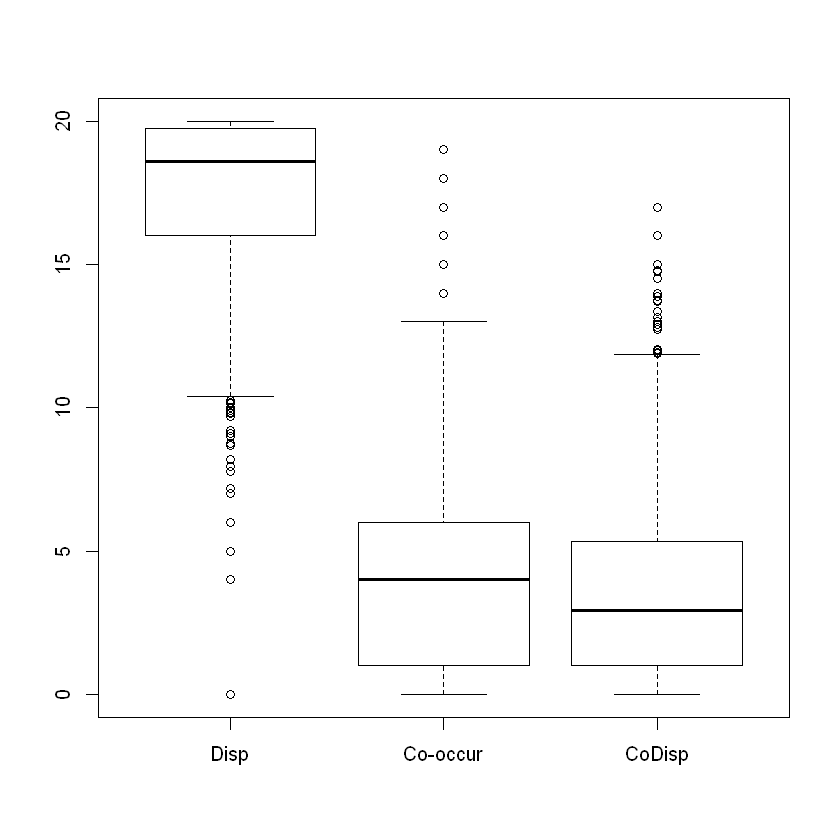

In [8]:
boxplot(res2, names=c('Disp', 'Co-occur', 'CoDisp'))

We can see that plant species have between 0 and 17 available lemur dispersers (i.e. co-occurring and able to disperse the seeds; CoDisp in the boxplot), with each species having 3.6 dispersers in average. Most of them seem to have less than 5 available dispersers.

In [9]:
res2 <- na.omit(res2)      # we remove the 5293 species that have always been defined as non-endozoochorous (i.e. in every imputed dataset)
res2_5less <- res2[res2$Co.occurring_Disperser_lemurs<=5, ]
nrow(res2_5less)/3018*100   # we have 3018 endozoochorous species for which we have distribution data.

[1] 74.42015

<div class="alert alert-block alert-info">
Almost __3/4__ of the plant species studied have __5 or less__ available dispersers.<br>
*Note: the 3018 plant species studied represent 86% of the animal-dispersed Madagascan plants.*

In [10]:
res2_0 <- res2[res2$Co.occurring_Disperser_lemurs==0, ]
nrow(res2_0)

[1] 624

<div class="alert alert-block alert-info">
__21%__ of plant species __do not have any__ available lemur disperser.

In [11]:
res2_20_0 <- res2[res2$Dispersers==20 & res2$Co.occurring_Disperser_lemurs==0, ]
nrow(res2_20_0)

[1] 103

<div class="alert alert-block alert-info">
According to their seed size, 103 plant species could potentially be dispersed by 20 species of lemurs but, due to their distribution, they do not have any disperser available.

<br>
<br>
## Histogram showing the number of plant species vs the number of (co-occurring/disperser/co-occurring & disperser) lemurs

In [19]:
library(ggplot2);

Warning message:
"Removed 5293 rows containing non-finite values (stat_bin)."

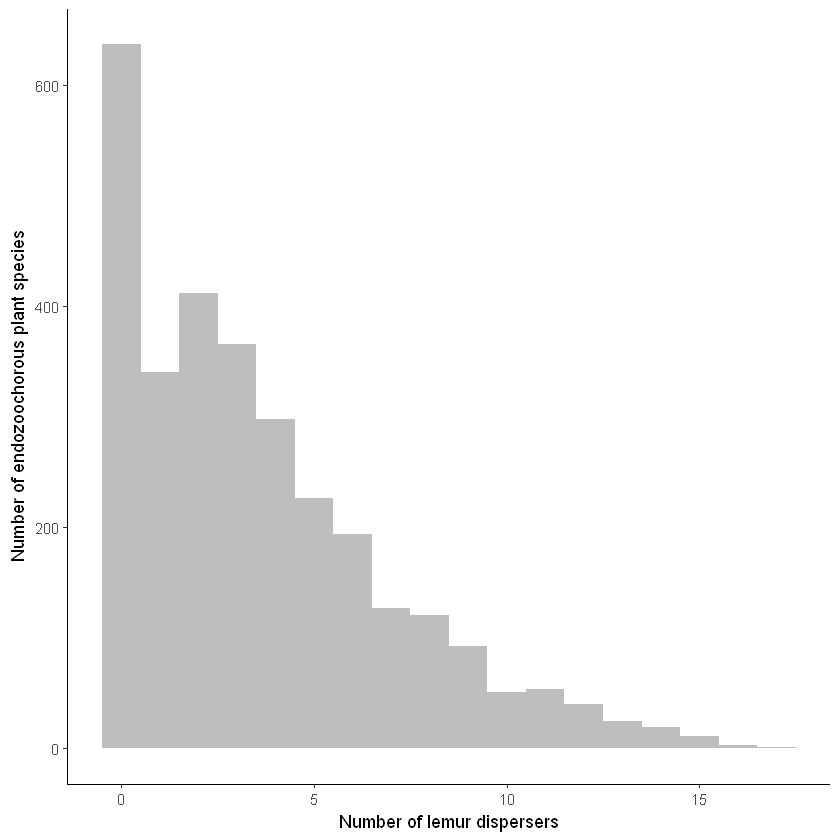

In [36]:
## Co-occurring disperser lemurs
ggplot(data = res2, aes(x = Co.occurring_Disperser_lemurs)) + 
geom_histogram(binwidth=1, fill="gray") +
ylab("Number of endozoochorous plant species") +
xlab("Number of lemur dispersers") +
theme_classic()

Warning message:
"Removed 5293 rows containing non-finite values (stat_bin)."

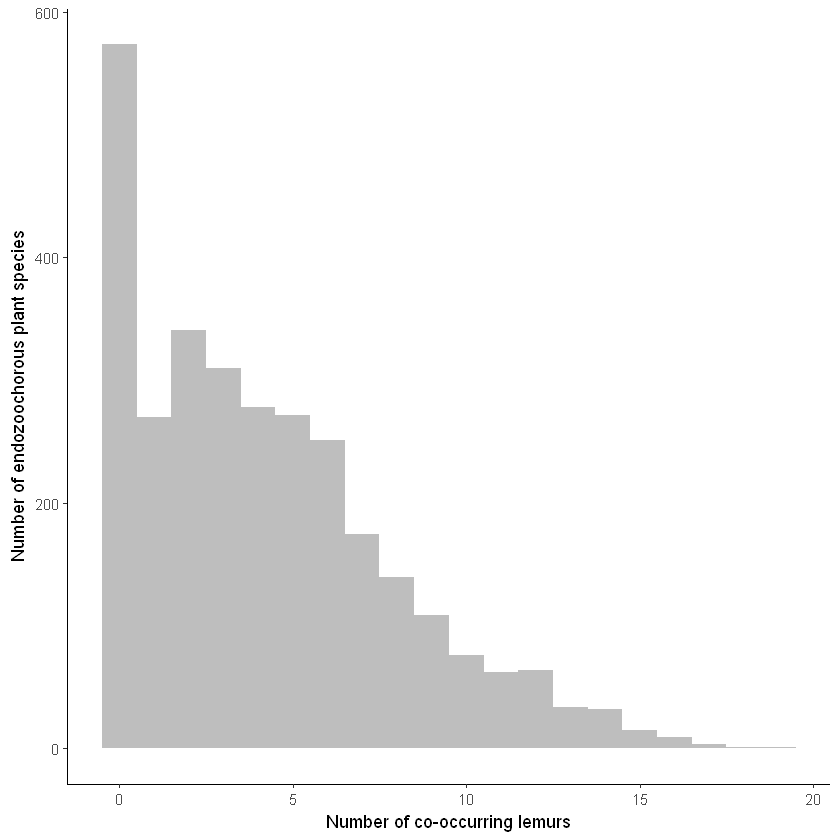

In [37]:
## Co-occurring lemurs
ggplot(data = res2, aes(x = Co.occurring_lemurs)) + 
geom_histogram(binwidth=1, fill="gray") +
ylab("Number of endozoochorous plant species") +
xlab("Number of co-occurring lemurs") +
theme_classic()

Warning message:
"Removed 5293 rows containing non-finite values (stat_bin)."

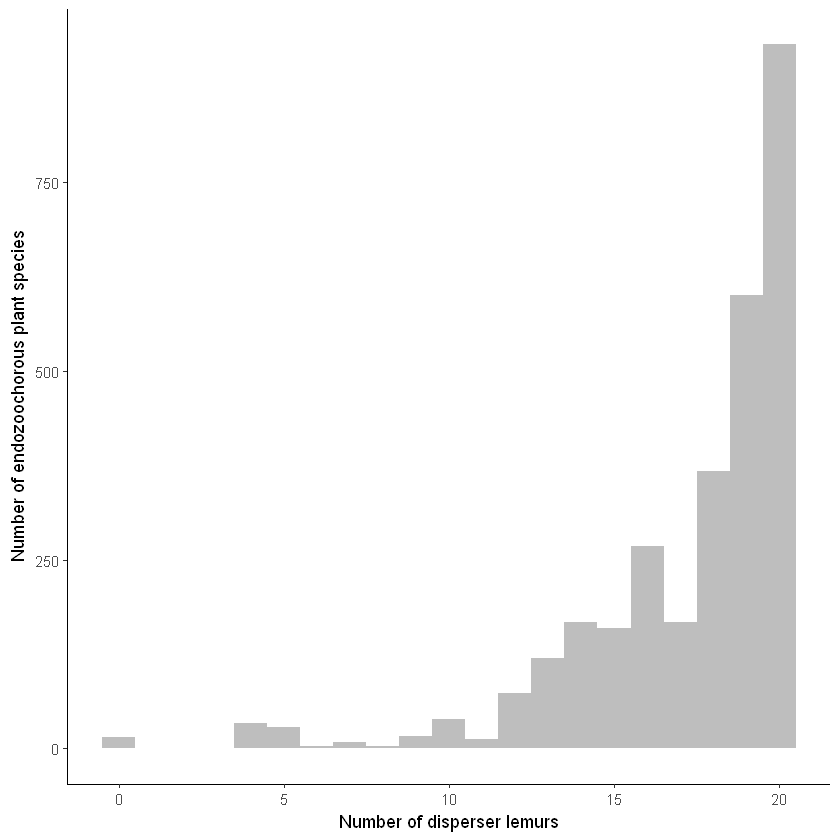

In [38]:
## Disperser lemurs
ggplot(data = res2, aes(x = Dispersers)) + 
geom_histogram(binwidth=1, fill="gray") +
ylab("Number of endozoochorous plant species") +
xlab("Number of disperser lemurs") +
theme_classic()

<br>
The best would be to have all those graphs combined into a single one.

In [41]:
res3 <- read.csv("LemSpatialRes2.csv", sep=";") # an "unrolled" version of the "res" dataframe
str(res3)

'data.frame':	9054 obs. of  2 variables:
 $ type: Factor w/ 3 levels "co","codisp",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ nb  : num  0 0 0 0 0 0 0 0 0 0 ...


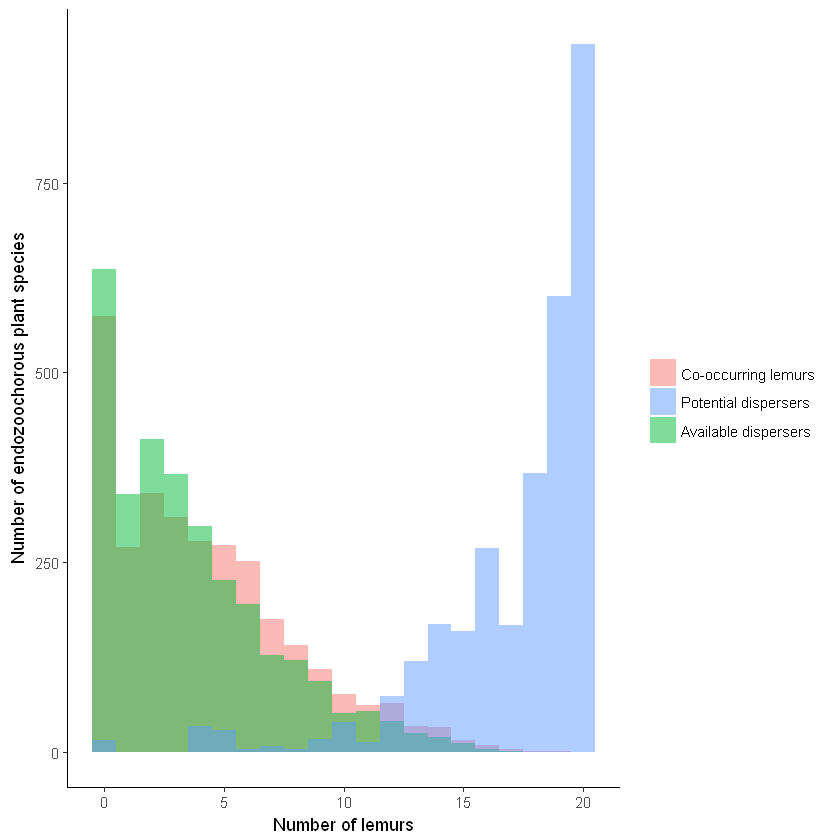

In [42]:
## All together
ggplot(data = res3, aes(x = nb, fill=type)) + 
geom_histogram(binwidth=1, position="identity",alpha=0.5) + 
ylab("Number of endozoochorous plant species") +
xlab("Number of lemurs") +
theme_classic() +
theme(legend.title=element_blank()) +
scale_fill_discrete(breaks=c("co","disp","codisp"), labels = c("Co-occurring lemurs", "Potential dispersers", "Available dispersers"))

Frequency histogram of the number of lemur species i) co-occurring, ii) able to disperse (i.e. potential dispersers) and iii) co-occurring and able to disperse (i.e. available dispersers) endozoochorous plant species (N=3001).